# Plug flow reactor simulation of Thruster

![caption](Graphics/thruster-details.png)


In [1]:
import cantera as ct
import numpy as np

from matplotlib import pyplot as plt
import csv
import os
import itertools
import pandas as pd

In [2]:
# default if not using SLURM array
cat_area_per_vol = 6e5 # m2/m3
temperature_c = 400 # ºC

# input file containing the reaction mechanism
cti_file = '../RMG-model/cantera/chem_annotated.cti'

In [3]:
cat_area_per_vol_options = [3e2, 3e3, 3e4, 3e5, 6e5, 9e5, 1.2e6, 3e6, 3e7, 3e8] # m2/m3
temperature_c_options = [200, 300, 400, 500, 600] # ºC
settings  = list(itertools.product(cat_area_per_vol_options, temperature_c_options))
print(f"Settings aray is from 0 to {len(settings)-1} ")

Settings aray is from 0 to 49 


In [4]:
task_number = int(os.getenv('SLURM_ARRAY_TASK_ID', default='0'))
task_min = int(os.getenv('SLURM_ARRAY_TASK_MIN', default='0'))
task_max = int(os.getenv('SLURM_ARRAY_TASK_MAX', default='0'))

if task_max > 0:
    print("Using SLURM array job.")
    
    cti_file = 'chem_annotated.cti'
    print(f"Using cantera input file {os.path.abspath(cti_file)}")

    print(f"Task ID {task_number} in array from {task_min} to {task_max}")

    cat_area_per_vol, temperature_c = settings[task_number]


In [5]:
if task_number == 0:
    import json
    setting_file_directory = '..' if task_max else 'rocketman'
    with open(os.path.join(setting_file_directory,'settings.json'),'w') as fp:
        json.dump(settings, fp)

In [6]:
print(f"Catalyst area per volume {cat_area_per_vol :.2e} m2/m3")
print(f"Initial temperature {temperature_c :.1f} ºC")

Catalyst area per volume 6.00e+05 m2/m3
Initial temperature 400.0 ºC


In [7]:


gas=ct.Solution(cti_file)
surf = ct.Interface(cti_file,'surface1', [gas])

In [8]:
gas()


  gas:

       temperature             300  K
          pressure          101325  Pa
           density         0.81974  kg/m^3
  mean mol. weight         20.1797  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy          1905.6        3.845e+04     J
   internal energy      -1.217e+05       -2.456e+06     J
           entropy          7257.7        1.465e+05     J/K
    Gibbs function     -2.1754e+06        -4.39e+07     J
 heat capacity c_p          1030.1        2.079e+04     J/K
 heat capacity c_v          618.03        1.247e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                Ne              1                1         -17.5994
     [  +63 minor]              0                0



In [9]:
print(", ".join(gas.species_names))

Ne, NH3(2), NH2OH(3), HNO3(4), CH3OH(5), H2O(6), N2(7), O2(8), NO2(9), NO(10), N2O(11), CO2(12), H2(13), CO(14), CH4(15), C2H6(16), CH2O(17), CH3(18), C3H8(19), H(20), C2H5(21), HCO(22), CH3CHO(23), OH(24), C2H4(25), O(36), Ar(37), He(38), HO2(39), H2O2(40), HOCO(41), CH2(42), CH2(S)(43), CH(44), CH2OH(45), CH3O(46), HCOH(47), CH3OO(48), CH2CO(49), C2H3(50), C(51), C2H2(52), C2H(53), CH3OOH(54), CH2OOH(55), HOCH2O(56), HOCHO(57), C2H5O(58), C2H5O2(59), C2H5O2(60), cC2H4O(61), CH2CHO(62), H2CC(63), CH3CO(64), C2H4O(65), C2H5O(66), C2H3O2(67), CHCHO(68), OCHCHO(69), NH2(85), H2NO(88), HNOH(93), NO3(95), H2NO3(239)


In [10]:
print(", ".join(surf.species_names))

X(1), HX(26), OX(27), CH3X(28), HOX(29), H2OX(30), CO2X(31), OCX(32), CX(33), CH2X(34), CHX(35), H2NX(201), H3NX(202), H2NOX(203), H2NOX(204), H3NOX(205), NO2X(206), NO3X(207), HNO3X(208), CH3OX(209), CH3OX(210), CH4OX(211)




This example solves a plug flow reactor problem, with coupled surface and gas chemistry.





In [11]:
# unit conversion factors to SI
cm = 0.01 # m
minute = 60.0  # s

In [12]:
#######################################################################
# Input Parameters for combustor
#######################################################################
mass_flow_rate =  0.5e-3 # kg/s
#temperature_c = 550.0  # Initial Temperature in Celsius
print(f"Initial temperature {temperature_c :.1f} ºC")
pressure = ct.one_atm # constant

length = 1.1 * cm  # Catalyst bed length. 11mm
cross_section_area = np.pi * (0.9*cm)**2  # Catalyst bed area.  18mm diameter circle.

### Catalyst properties. Some are hard to estimate
# if we can, update this lit value or verify the value richard calculated
cat_specific_area = 140 # m2/g
cat_density = 2 / cm**3 # 2 g/m3
print(f"Catalyst density {cat_density :.2e} g/m3")
#cat_area_per_vol = cat_specific_area * cat_density # m2/m3
#cat_area_per_vol *= 1e-3 # REDUCE BY A LOT
print(f"Catalyst area per volume {cat_area_per_vol :.2e} m2/m3")


porosity = 0.38  # Catalyst bed porosity (0.38)
# Al2O3 particles are about 0.7mm diameter

Initial temperature 400.0 ºC
Catalyst density 2.00e+06 g/m3
Catalyst area per volume 6.00e+05 m2/m3


In [13]:
output_filename = 'surf_pfr_output.csv'

# The PFR will be simulated by a chain of 'NReactors' stirred reactors.
NReactors = 2001
# dt = 1.0

#####################################################################

temperature_kelvin = temperature_c + 273.15  # convert to Kelvin

# import the gas model and set the initial conditions
gas = ct.Solution(cti_file, 'gas')

# From HAN-molefractions.ipynb
feed_mole_fractions = {
    'NH3(2)': 0.031,
    'NH2OH(3)': 0.32,
    'HNO3(4)': 0.35,
    'CH3OH(5)': 0.21,
    'H2O(6)': 0.09,
}
gas.TPX = temperature_kelvin, pressure, feed_mole_fractions


# import the surface model
surf = ct.Interface(cti_file,'surface1', [gas])
surf.TP = temperature_kelvin, pressure
surf.coverages = 'X(1):1.0'

r_len = length/(NReactors-1) 
r_vol = cross_section_area * r_len * porosity # gas volume

outfile = open(output_filename,'w')
writer = csv.writer(outfile)
writer.writerow(['Distance (mm)', 'T (C)', 'P (atm)'] +
                gas.species_names + surf.species_names + ['gas_heat','surface_heat','alpha'])

# catalyst area in one reactor
cat_area = cat_area_per_vol * r_vol

# Not sure we need the velocity
velocity = mass_flow_rate / (gas.density * cross_section_area)

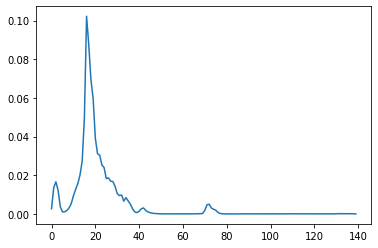


  surface1:

       temperature          673.15  K
          pressure          101325  Pa
           density     5.14154e-06  kg/m^3
  mean mol. weight         198.745  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy     -1.9749e+05       -3.925e+07     J
   internal energy     -1.9749e+05       -3.925e+07     J
           entropy          66.797        1.328e+04     J/K
    Gibbs function     -2.4246e+05       -4.819e+07     J
 heat capacity c_p          27.589             5483     J/K
 heat capacity c_v          27.589             5483     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
              X(1)       0.819763         0.804657        -0.198779
            HX(26)    4.31035e-05      4.25278e-05         -14.5002
            OX(27)       0.114992         0.122131         -38.9304
           HOX(29)    2

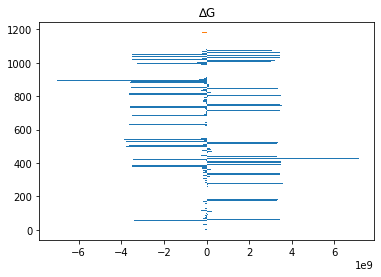

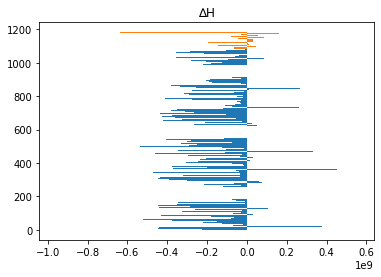

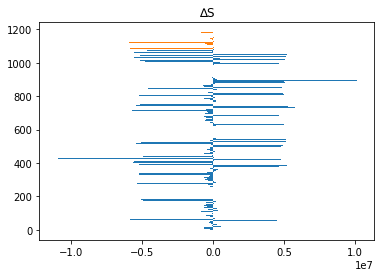

array([ 8.19762833e-01,  4.31035022e-05,  1.14992386e-01,  2.33102754e-21,
        2.57182500e-07,  3.85144366e-04,  1.07343271e-08,  6.48162524e-02,
        3.32162948e-12,  1.97346243e-20,  2.09055831e-12, -5.17984359e-17,
       -2.60867336e-16, -1.99659182e-50, -2.99272129e-28, -2.91943731e-30,
        1.21106024e-08,  1.50385356e-28,  1.41590636e-24,  4.80870195e-27,
        8.51574247e-19,  7.61131877e-26])

In [16]:
# To find the starting coverages, we run the gas to equilibrium,
# (i.e mostly burned products)  then put that in steady state
# with the surface.
TPY = gas.TPY # store to restore
gas.equilibrate('TP')
r = ct.IdealGasReactor(gas, energy='off')
r.volume = r_vol
rsurf = ct.ReactorSurface(surf, r, A=cat_area)
sim = ct.ReactorNet([r])
plt.plot(sim.advance_to_steady_state(return_residuals=True))
plt.show()
surf()
starting_coverages = surf.coverages

print("At equilibrium")
plt.barh(np.arange(len(gas.delta_gibbs)),gas.delta_gibbs)
plt.barh(len(gas.delta_gibbs)+np.arange(len(surf.delta_gibbs)),surf.delta_gibbs)
plt.title("∆G")
plt.show()
plt.barh(np.arange(len(gas.delta_enthalpy)),gas.delta_enthalpy)
plt.barh(len(gas.delta_enthalpy)+np.arange(len(surf.delta_enthalpy)),surf.delta_enthalpy)
plt.title('∆H')
plt.show()
plt.barh(np.arange(len(gas.delta_entropy)),gas.delta_entropy)
plt.barh(len(gas.delta_entropy)+np.arange(len(surf.delta_entropy)),surf.delta_entropy)
plt.title('∆S')
plt.show()

gas.TPY = TPY # restore to starting conditions
del(r, rsurf)
starting_coverages

<BarContainer object of 64 artists>

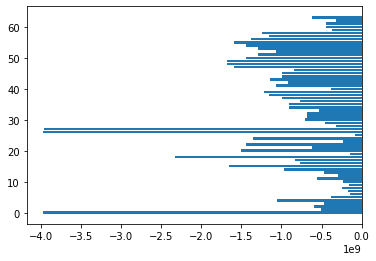

In [17]:
plt.barh(np.arange(len(gas.chemical_potentials)),gas.chemical_potentials)

In [18]:
# gas.equilibrate('TP')

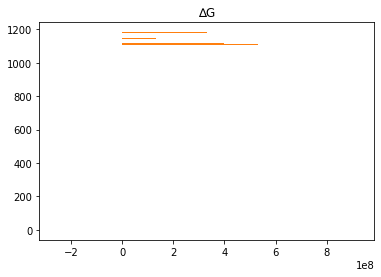

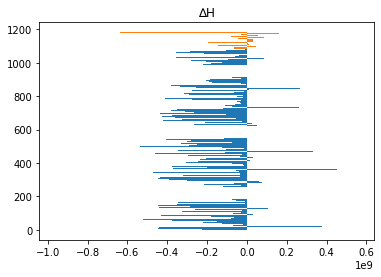

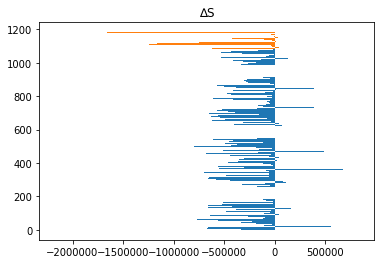

In [19]:
plt.barh(np.arange(len(gas.delta_gibbs)),gas.delta_gibbs)
plt.barh(len(gas.delta_gibbs)+np.arange(len(surf.delta_gibbs)),surf.delta_gibbs)
plt.title("∆G")
plt.show()
plt.barh(np.arange(len(gas.delta_enthalpy)),gas.delta_enthalpy)
plt.barh(len(gas.delta_enthalpy)+np.arange(len(surf.delta_enthalpy)),surf.delta_enthalpy)
plt.title('∆H')
plt.show()
plt.barh(np.arange(len(gas.delta_entropy)),gas.delta_entropy)
plt.barh(len(gas.delta_entropy)+np.arange(len(surf.delta_entropy)),surf.delta_entropy)
plt.title('∆S')
plt.show()

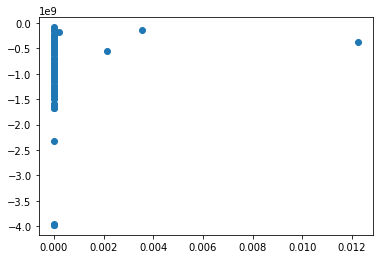

In [20]:
plt.plot(gas.concentrations, gas.chemical_potentials, 'o')

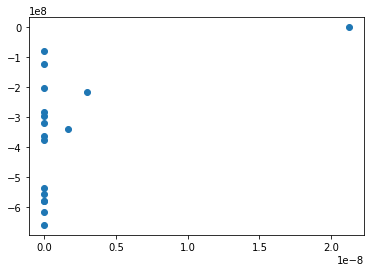

In [21]:
plt.plot(surf.concentrations, surf.chemical_potentials, 'o')

In [22]:
def report_rates(n=8):
    print("\nHighest net rates of progress, gas")
    for i in np.argsort(abs(gas.net_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.net_rates_of_progress[i]:8.1g}")
    print("\nHighest net rates of progress, surface")
    for i in np.argsort(abs(surf.net_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {cat_area_per_vol*surf.net_rates_of_progress[i]:8.1g}")
    print("\nHighest forward rates of progress, gas")
    for i in np.argsort(abs(gas.forward_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.forward_rates_of_progress[i]:8.1g}")
    print("\nHighest forward rates of progress, surface")
    for i in np.argsort(abs(surf.forward_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {cat_area_per_vol*surf.forward_rates_of_progress[i]:8.1g}")
    print("\nHighest reverse rates of progress, gas")
    for i in np.argsort(abs(gas.reverse_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.reverse_rates_of_progress[i]:8.1g}")
    print("\nHighest reverse rates of progress, surface")
    for i in np.argsort(abs(surf.reverse_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {cat_area_per_vol*surf.reverse_rates_of_progress[i]:8.1g}")

    print(f"\nSurface rates have been scaled by surface/volume ratio {cat_area_per_vol:.1e} m2/m3")
    print("So are on a similar basis of volume of reactor (though porosity not yet accounted for)")
    print(" kmol / m3 / s")
report_rates()


Highest net rates of progress, gas
 47 : NO2(9) + OH(24) (+M) <=> HNO3(4) (+M)               -9e-27
244 : HO2(39) + OH(24) <=> H2O(6) + O2(8)                 -2e-27
240 : H(20) + O2(8) (+M) <=> HO2(39) (+M)                  2e-29
274 : H2O2(40) (+M) <=> 2 OH(24) (+M)                      2e-29
265 : HO2(39) + NO(10) <=> NO2(9) + OH(24)                 5e-30
  0 : 2 NO2(9) <=> 2 NO(10) + O2(8)                       -4e-30
225 : NO2(9) + O(36) <=> NO(10) + O2(8)                   -3e-30

Highest net rates of progress, surface
  2 : H2O(6) + X(1) <=> H2OX(30)                          -2e+04
 43 : O2(8) + 2 X(1) <=> 2 OX(27)                          4e+02
 57 : CO2(12) + X(1) <=> CO2X(31)                          3e+01
  5 : H2(13) + 2 X(1) <=> 2 HX(26)                            -1
 10 : H2O(6) + 2 X(1) <=> HOX(29) + HX(26)                  -0.1
 58 : CO(14) + X(1) <=> OCX(32)                             -0.1
 20 : NO2(9) + X(1) <=> NO2X(206)                         0.0006

Highest forwa

In [23]:
def report_rate_constants(n=8):
    print("\nHighest forward rate constants, gas")
    for i in np.argsort(abs(gas.forward_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.forward_rate_constants[i]:8.1e}")
    print("\nHighest forward rate constants, surface")
    for i in np.argsort(abs(surf.forward_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {surf.forward_rate_constants[i]:8.1e}")
    print("\nHighest reverse rate constants, gas")
    for i in np.argsort(abs(gas.reverse_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.reverse_rate_constants[i]:8.1e}")
    print("\nHighest reverse rate constants, surface")
    for i in np.argsort(abs(surf.reverse_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {surf.reverse_rate_constants[i]:8.1e}")

    print("Units are a combination of kmol, m^3 and s, that depend on the rate expression for the reaction.")
report_rate_constants()


Highest forward rate constants, gas
868 : CH3CO(64) + CH3O(46) <=> CH2O(17) + CH3CHO(23)     5.4e+11
905 : CH3CO(64) + HOCO(41) <=> CH2CO(49) + HOCHO(57)     5.4e+11
655 : C2H5(21) + HOCO(41) <=> C2H4(25) + HOCHO(57)       5.4e+11
660 : CH3O(46) + HOCO(41) <=> CH2O(17) + HOCHO(57)       5.4e+11
888 : CH3CO(64) + HCO(22) <=> CH2CO(49) + CH2O(17)       5.4e+11
891 : 2 CH3CO(64) <=> CH2CO(49) + CH3CHO(23)             5.4e+11
872 : C2H5(21) + CH3CO(64) <=> C2H4(25) + CH3CHO(23)     5.4e+11

Highest forward rate constants, surface
 77 : CHX(35) + X(1) <=> CX(33) + HX(26)                 3.1e+21
 62 : CH2X(34) + HX(26) <=> CH3X(28) + X(1)              3.1e+21
 76 : CHX(35) + HX(26) <=> CH2X(34) + X(1)               3.1e+21
 45 : HX(26) + OX(27) <=> HOX(29) + X(1)                 1.7e+19
 65 : CH2X(34) + HOX(29) <=> CH3X(28) + OX(27)           9.0e+18
 88 : CHX(35) + HOX(29) <=> CH2X(34) + OX(27)            4.4e+18
 61 : CX(33) + OX(27) <=> OCX(32) + X(1)                 3.7e+18

Highest rev

In [25]:
gas.TPX = temperature_kelvin, pressure, feed_mole_fractions

In [26]:
# The plug flow reactor is represented by a linear chain of zero-dimensional
# reactors. The gas at the inlet to the first one has the specified inlet
# composition, and for all others the inlet composition is fixed at the
# composition of the reactor immediately upstream. Since in a PFR model there
# is no diffusion, the upstream reactors are not affected by any downstream
# reactors, and therefore the problem may be solved by simply marching from
# the first to last reactor, integrating each one to steady state.

TDY = gas.TDY
cov = surf.coverages

# create a new reactor
gas.TDY = TDY
r = ct.IdealGasReactor(gas, energy='on')
r.volume = r_vol

# create a reservoir to represent the reactor immediately upstream. Note
# that the gas object is set already to the state of the upstream reactor
upstream = ct.Reservoir(gas, name='upstream')

# create a reservoir for the reactor to exhaust into. The composition of
# this reservoir is irrelevant.
downstream = ct.Reservoir(gas, name='downstream')

# Add the reacting surface to the reactor. The area is set to the desired
# catalyst area in the reactor.
rsurf = ct.ReactorSurface(surf, r, A=cat_area)

# The mass flow rate into the reactor will be fixed by using a
# MassFlowController object.
m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)

# We need an outlet to the downstream reservoir. This will determine the
# pressure in the reactor. The value of K will only affect the transient
# pressure difference.
v = ct.PressureController(r, downstream, master=m, K=1e-5)

sim = ct.ReactorNet([r])
sim.max_err_test_fails = 24

# set relative and absolute tolerances on the simulation
sim.rtol = 1.0e-13
sim.atol = 1.0e-18

sim.verbose = False

# surf.set_multiplier(0.)  # turn off surface reactions
# surf.set_multiplier(1e6)  # make surface reactions a million times faster


print('    distance(mm)     T (C)    NH3(2)   NH2OH(3)     HNO3(4)    CH3OH(5)  alpha')
for n in range(NReactors):
    # Set the state of the reservoir to match that of the previous reactor
    gas.TDY = TDY = r.thermo.TDY

    upstream.syncState()
    sim.reinitialize()
    try:
#         the default is residual_threshold = sim.rtol*10
        sim.advance_to_steady_state(residual_threshold = sim.rtol*100)
#        sim.advance_to_steady_state()

    except ct.CanteraError:
        t = sim.time
        sim.set_initial_time(0)
        gas.TDY = TDY
        r.syncState()
        sim.reinitialize()
        print(f"Couldn't reach {t:.1g} s so going to {0.1*t:.1g} s")
        sim.advance(0.1*t)
        #report_rates()
        #report_rate_constants()
 
    dist = n * r_len * 1.0e3   # distance in mm
        
    gas_heat = np.dot(gas.net_rates_of_progress, gas.delta_enthalpy) # heat evolved by gas phase reaction
    surface_heat = cat_area_per_vol * np.dot(surf.net_rates_of_progress, surf.delta_enthalpy) # heat evolved by surf phase reaction 
    alpha = surface_heat / (surface_heat + gas_heat) # fraction of heat release that is on surface.

    if not n % 10:
        print('    {:10f}  {:7.1f}  {:10f}  {:10f}  {:10f} {:10f}  {:5.1e}'.format(dist, r.T-273.15, *gas['NH3(2)','NH2OH(3)','HNO3(4)','CH3OH(5)'].X, alpha ))

    # write the gas mole fractions and surface coverages vs. distance
    writer.writerow([dist, r.T - 273.15, r.thermo.P/ct.one_atm] +
                    list(gas.X) + list(surf.coverages) + [gas_heat, surface_heat, alpha])
    
    #report_rates()
    #report_rate_constants()

outfile.close()
print("Results saved to '{0}'".format(output_filename))

    distance(mm)     T (C)    NH3(2)   NH2OH(3)     HNO3(4)    CH3OH(5)  alpha
      0.000000    401.0    0.031496    0.318452    0.349492   0.209605  1.0e+00
      0.055000    410.4    0.036567    0.306544    0.347964   0.207834  1.0e+00
      0.110000    419.0    0.041313    0.295271    0.346526   0.206193  1.0e+00
      0.165000    427.2    0.045817    0.284479    0.345154   0.204647  1.0e+00
      0.220000    435.0    0.050178    0.273964    0.343821   0.203158  1.0e+00
      0.275000    442.7    0.054495    0.263508    0.342497   0.201689  1.0e+00
      0.330000    450.5    0.058868    0.252891    0.341151   0.200204  1.0e+00
      0.385000    458.7    0.063399    0.241884    0.339752   0.198664  1.0e+00
      0.440000    467.4    0.068199    0.230239    0.338266   0.197029  1.0e+00
      0.495000    476.9    0.073399    0.217665    0.336652   0.195248  1.0e+00
      0.550000    487.7    0.079171    0.203805    0.334854   0.193256  1.0e+00
      0.605000    500.4    0.085746    0.

CanteraError: 
***********************************************************************
CanteraError thrown by CVodesIntegrator::integrate:
CVodes error encountered. Error code: -10
At t = 0 repeated recoverable right-hand side function errors.

Exceptions caught during RHS evaluation:

***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = inf
ydot[2] = -nan
ydot[3] = -inf
ydot[4] = -nan
ydot[5] = -nan
ydot[6] = -nan
ydot[7] = -nan
ydot[8] = -nan
ydot[9] = -inf
ydot[10] = -nan
ydot[11] = -nan
ydot[12] = -inf
ydot[13] = -inf
ydot[14] = -nan
ydot[15] = -nan
ydot[16] = -nan
ydot[17] = -nan
ydot[18] = -nan
ydot[19] = -nan
ydot[20] = -nan
ydot[21] = -inf
ydot[22] = -nan
ydot[23] = -nan
ydot[24] = -nan
ydot[25] = -nan
ydot[26] = -nan
ydot[27] = -nan
ydot[28] = -nan
ydot[29] = -inf
ydot[30] = -nan
ydot[31] = -nan
ydot[32] = -nan
ydot[33] = -nan
ydot[34] = -nan
ydot[35] = -nan
ydot[36] = -nan
ydot[37] = -nan
ydot[38] = -nan
ydot[39] = -inf
ydot[40] = -nan
ydot[41] = -nan
ydot[42] = -nan
ydot[43] = -nan
ydot[44] = -nan
ydot[45] = -nan
ydot[46] = -nan
ydot[47] = -nan
ydot[48] = -nan
ydot[49] = -inf
ydot[50] = -nan
ydot[51] = -nan
ydot[52] = -inf
ydot[53] = -nan
ydot[54] = -nan
ydot[55] = -inf
ydot[56] = -nan
ydot[57] = -nan
ydot[58] = -inf
ydot[59] = -nan
ydot[60] = -nan
ydot[61] = -inf
ydot[62] = -nan
ydot[63] = -nan
ydot[64] = -nan
ydot[65] = -nan
ydot[66] = -inf
ydot[67] = -nan
ydot[68] = -nan
ydot[69] = -nan
ydot[70] = -inf
ydot[71] = -nan
ydot[72] = -nan
ydot[73] = inf
ydot[74] = -inf
ydot[75] = inf
ydot[76] = -nan
ydot[77] = -nan
ydot[79] = -inf
ydot[80] = -inf
ydot[81] = -nan
ydot[82] = -nan
ydot[83] = -inf
ydot[84] = -inf
ydot[85] = inf
ydot[86] = -inf
ydot[87] = -nan
ydot[88] = -nan
***********************************************************************


***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = inf
ydot[2] = -nan
ydot[3] = -inf
ydot[4] = -nan
ydot[5] = -nan
ydot[6] = -nan
ydot[7] = -nan
ydot[8] = -nan
ydot[9] = -inf
ydot[10] = -nan
ydot[11] = -nan
ydot[12] = -inf
ydot[13] = -inf
ydot[14] = -nan
ydot[15] = -nan
ydot[16] = -nan
ydot[17] = -nan
ydot[18] = -nan
ydot[19] = -nan
ydot[20] = -nan
ydot[21] = -inf
ydot[22] = -nan
ydot[23] = -nan
ydot[24] = -nan
ydot[25] = -nan
ydot[26] = -nan
ydot[27] = -nan
ydot[28] = -nan
ydot[29] = -inf
ydot[30] = -nan
ydot[31] = -nan
ydot[32] = -nan
ydot[33] = -nan
ydot[34] = -nan
ydot[35] = -nan
ydot[36] = -nan
ydot[37] = -nan
ydot[38] = -nan
ydot[39] = -inf
ydot[40] = -nan
ydot[41] = -nan
ydot[42] = -nan
ydot[43] = -nan
ydot[44] = -nan
ydot[45] = -nan
ydot[46] = -nan
ydot[47] = -nan
ydot[48] = -nan
ydot[49] = -inf
ydot[50] = -nan
ydot[51] = -nan
ydot[52] = -inf
ydot[53] = -nan
ydot[54] = -nan
ydot[55] = -inf
ydot[56] = -nan
ydot[57] = -nan
ydot[58] = -inf
ydot[59] = -nan
ydot[60] = -nan
ydot[61] = -inf
ydot[62] = -nan
ydot[63] = -nan
ydot[64] = -nan
ydot[65] = -nan
ydot[66] = -inf
ydot[67] = -nan
ydot[68] = -nan
ydot[69] = -nan
ydot[70] = -inf
ydot[71] = -nan
ydot[72] = -nan
ydot[73] = inf
ydot[74] = -inf
ydot[75] = inf
ydot[76] = -nan
ydot[77] = -nan
ydot[79] = -inf
ydot[80] = -inf
ydot[81] = -nan
ydot[82] = -nan
ydot[83] = -inf
ydot[84] = -inf
ydot[85] = inf
ydot[86] = -inf
ydot[87] = -nan
ydot[88] = -nan
***********************************************************************


***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = inf
ydot[2] = -nan
ydot[3] = -inf
ydot[4] = -nan
ydot[5] = -nan
ydot[6] = -nan
ydot[7] = -nan
ydot[8] = -nan
ydot[9] = -inf
ydot[10] = -nan
ydot[11] = -nan
ydot[12] = -inf
ydot[13] = -inf
ydot[14] = -nan
ydot[15] = -nan
ydot[16] = -nan
ydot[17] = -nan
ydot[18] = -nan
ydot[19] = -nan
ydot[20] = -nan
ydot[21] = -inf
ydot[22] = -nan
ydot[23] = -nan
ydot[24] = -nan
ydot[25] = -nan
ydot[26] = -nan
ydot[27] = -nan
ydot[28] = -nan
ydot[29] = -inf
ydot[30] = -nan
ydot[31] = -nan
ydot[32] = -nan
ydot[33] = -nan
ydot[34] = -nan
ydot[35] = -nan
ydot[36] = -nan
ydot[37] = -nan
ydot[38] = -nan
ydot[39] = -inf
ydot[40] = -nan
ydot[41] = -nan
ydot[42] = -nan
ydot[43] = -nan
ydot[44] = -nan
ydot[45] = -nan
ydot[46] = -nan
ydot[47] = -nan
ydot[48] = -nan
ydot[49] = -inf
ydot[50] = -nan
ydot[51] = -nan
ydot[52] = -inf
ydot[53] = -nan
ydot[54] = -nan
ydot[55] = -inf
ydot[56] = -nan
ydot[57] = -nan
ydot[58] = -inf
ydot[59] = -nan
ydot[60] = -nan
ydot[61] = -inf
ydot[62] = -nan
ydot[63] = -nan
ydot[64] = -nan
ydot[65] = -nan
ydot[66] = -inf
ydot[67] = -nan
ydot[68] = -nan
ydot[69] = -nan
ydot[70] = -inf
ydot[71] = -nan
ydot[72] = -nan
ydot[73] = inf
ydot[74] = -inf
ydot[75] = inf
ydot[76] = -nan
ydot[77] = -nan
ydot[79] = -inf
ydot[80] = -inf
ydot[81] = -nan
ydot[82] = -nan
ydot[83] = -inf
ydot[84] = -inf
ydot[85] = inf
ydot[86] = -inf
ydot[87] = -nan
ydot[88] = -nan
***********************************************************************


***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = inf
ydot[2] = -nan
ydot[3] = -inf
ydot[4] = -nan
ydot[5] = -nan
ydot[6] = -nan
ydot[7] = -nan
ydot[8] = -nan
ydot[9] = -inf
ydot[10] = -nan
ydot[11] = -nan
ydot[12] = -inf
ydot[13] = -inf
ydot[14] = -nan
ydot[15] = -nan
ydot[16] = -nan
ydot[17] = -nan
ydot[18] = -nan
ydot[19] = -nan
ydot[20] = -nan
ydot[21] = -inf
ydot[22] = -nan
ydot[23] = -nan
ydot[24] = -nan
ydot[25] = -nan
ydot[26] = -nan
ydot[27] = -nan
ydot[28] = -nan
ydot[29] = -inf
ydot[30] = -nan
ydot[31] = -nan
ydot[32] = -nan
ydot[33] = -nan
ydot[34] = -nan
ydot[35] = -nan
ydot[36] = -nan
ydot[37] = -nan
ydot[38] = -nan
ydot[39] = -inf
ydot[40] = -nan
ydot[41] = -nan
ydot[42] = -nan
ydot[43] = -nan
ydot[44] = -nan
ydot[45] = -nan
ydot[46] = -nan
ydot[47] = -nan
ydot[48] = -nan
ydot[49] = -inf
ydot[50] = -nan
ydot[51] = -nan
ydot[52] = -inf
ydot[53] = -nan
ydot[54] = -nan
ydot[55] = -inf
ydot[56] = -nan
ydot[57] = -nan
ydot[58] = -inf
ydot[59] = -nan
ydot[60] = -nan
ydot[61] = -inf
ydot[62] = -nan
ydot[63] = -nan
ydot[64] = -nan
ydot[65] = -nan
ydot[66] = -inf
ydot[67] = -nan
ydot[68] = -nan
ydot[69] = -nan
ydot[70] = -inf
ydot[71] = -nan
ydot[72] = -nan
ydot[73] = inf
ydot[74] = -inf
ydot[75] = inf
ydot[76] = -nan
ydot[77] = -nan
ydot[79] = -inf
ydot[80] = -inf
ydot[81] = -nan
ydot[82] = -nan
ydot[83] = -inf
ydot[84] = -inf
ydot[85] = inf
ydot[86] = -inf
ydot[87] = -nan
ydot[88] = -nan
***********************************************************************


***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = inf
ydot[2] = -nan
ydot[3] = -inf
ydot[4] = -nan
ydot[5] = -nan
ydot[6] = -nan
ydot[7] = -nan
ydot[8] = -nan
ydot[9] = -inf
ydot[10] = -nan
ydot[11] = -nan
ydot[12] = -inf
ydot[13] = -inf
ydot[14] = -nan
ydot[15] = -nan
ydot[16] = -nan
ydot[17] = -nan
ydot[18] = -nan
ydot[19] = -nan
ydot[20] = -nan
ydot[21] = -inf
ydot[22] = -nan
ydot[23] = -nan
ydot[24] = -nan
ydot[25] = -nan
ydot[26] = -nan
ydot[27] = -nan
ydot[28] = -nan
ydot[29] = -inf
ydot[30] = -nan
ydot[31] = -nan
ydot[32] = -nan
ydot[33] = -nan
ydot[34] = -nan
ydot[35] = -nan
ydot[36] = -nan
ydot[37] = -nan
ydot[38] = -nan
ydot[39] = -inf
ydot[40] = -nan
ydot[41] = -nan
ydot[42] = -nan
ydot[43] = -nan
ydot[44] = -nan
ydot[45] = -nan
ydot[46] = -nan
ydot[47] = -nan
ydot[48] = -nan
ydot[49] = -inf
ydot[50] = -nan
ydot[51] = -nan
ydot[52] = -inf
ydot[53] = -nan
ydot[54] = -nan
ydot[55] = -inf
ydot[56] = -nan
ydot[57] = -nan
ydot[58] = -inf
ydot[59] = -nan
ydot[60] = -nan
ydot[61] = -inf
ydot[62] = -nan
ydot[63] = -nan
ydot[64] = -nan
ydot[65] = -nan
ydot[66] = -inf
ydot[67] = -nan
ydot[68] = -nan
ydot[69] = -nan
ydot[70] = -inf
ydot[71] = -nan
ydot[72] = -nan
ydot[73] = inf
ydot[74] = -inf
ydot[75] = inf
ydot[76] = -nan
ydot[77] = -nan
ydot[79] = -inf
ydot[80] = -inf
ydot[81] = -nan
ydot[82] = -nan
ydot[83] = -inf
ydot[84] = -inf
ydot[85] = inf
ydot[86] = -inf
ydot[87] = -nan
ydot[88] = -nan
***********************************************************************


***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = inf
ydot[2] = -nan
ydot[3] = -inf
ydot[4] = -nan
ydot[5] = -nan
ydot[6] = -nan
ydot[7] = -nan
ydot[8] = -nan
ydot[9] = -inf
ydot[10] = -nan
ydot[11] = -nan
ydot[12] = -inf
ydot[13] = -inf
ydot[14] = -nan
ydot[15] = -nan
ydot[16] = -nan
ydot[17] = -nan
ydot[18] = -nan
ydot[19] = -nan
ydot[20] = -nan
ydot[21] = -inf
ydot[22] = -nan
ydot[23] = -nan
ydot[24] = -nan
ydot[25] = -nan
ydot[26] = -nan
ydot[27] = -nan
ydot[28] = -nan
ydot[29] = -inf
ydot[30] = -nan
ydot[31] = -nan
ydot[32] = -nan
ydot[33] = -nan
ydot[34] = -nan
ydot[35] = -nan
ydot[36] = -nan
ydot[37] = -nan
ydot[38] = -nan
ydot[39] = -inf
ydot[40] = -nan
ydot[41] = -nan
ydot[42] = -nan
ydot[43] = -nan
ydot[44] = -nan
ydot[45] = -nan
ydot[46] = -nan
ydot[47] = -nan
ydot[48] = -nan
ydot[49] = -inf
ydot[50] = -nan
ydot[51] = -nan
ydot[52] = -inf
ydot[53] = -nan
ydot[54] = -nan
ydot[55] = -inf
ydot[56] = -nan
ydot[57] = -nan
ydot[58] = -inf
ydot[59] = -nan
ydot[60] = -nan
ydot[61] = -inf
ydot[62] = -nan
ydot[63] = -nan
ydot[64] = -nan
ydot[65] = -nan
ydot[66] = -inf
ydot[67] = -nan
ydot[68] = -nan
ydot[69] = -nan
ydot[70] = -inf
ydot[71] = -nan
ydot[72] = -nan
ydot[73] = inf
ydot[74] = -inf
ydot[75] = inf
ydot[76] = -nan
ydot[77] = -nan
ydot[79] = -inf
ydot[80] = -inf
ydot[81] = -nan
ydot[82] = -nan
ydot[83] = -inf
ydot[84] = -inf
ydot[85] = inf
ydot[86] = -inf
ydot[87] = -nan
ydot[88] = -nan
***********************************************************************


***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = inf
ydot[2] = -nan
ydot[3] = -inf
ydot[4] = -nan
ydot[5] = -nan
ydot[6] = -nan
ydot[7] = -nan
ydot[8] = -nan
ydot[9] = -inf
ydot[10] = -nan
ydot[11] = -nan
ydot[12] = -inf
ydot[13] = -inf
ydot[14] = -nan
ydot[15] = -nan
ydot[16] = -nan
ydot[17] = -nan
ydot[18] = -nan
ydot[19] = -nan
ydot[20] = -nan
ydot[21] = -inf
ydot[22] = -nan
ydot[23] = -nan
ydot[24] = -nan
ydot[25] = -nan
ydot[26] = -nan
ydot[27] = -nan
ydot[28] = -nan
ydot[29] = -inf
ydot[30] = -nan
ydot[31] = -nan
ydot[32] = -nan
ydot[33] = -nan
ydot[34] = -nan
ydot[35] = -nan
ydot[36] = -nan
ydot[37] = -nan
ydot[38] = -nan
ydot[39] = -inf
ydot[40] = -nan
ydot[41] = -nan
ydot[42] = -nan
ydot[43] = -nan
ydot[44] = -nan
ydot[45] = -nan
ydot[46] = -nan
ydot[47] = -nan
ydot[48] = -nan
ydot[49] = -inf
ydot[50] = -nan
ydot[51] = -nan
ydot[52] = -inf
ydot[53] = -nan
ydot[54] = -nan
ydot[55] = -inf
ydot[56] = -nan
ydot[57] = -nan
ydot[58] = -inf
ydot[59] = -nan
ydot[60] = -nan
ydot[61] = -inf
ydot[62] = -nan
ydot[63] = -nan
ydot[64] = -nan
ydot[65] = -nan
ydot[66] = -inf
ydot[67] = -nan
ydot[68] = -nan
ydot[69] = -nan
ydot[70] = -inf
ydot[71] = -nan
ydot[72] = -nan
ydot[73] = inf
ydot[74] = -inf
ydot[75] = inf
ydot[76] = -nan
ydot[77] = -nan
ydot[79] = -inf
ydot[80] = -inf
ydot[81] = -nan
ydot[82] = -nan
ydot[83] = -inf
ydot[84] = -inf
ydot[85] = inf
ydot[86] = -inf
ydot[87] = -nan
ydot[88] = -nan
***********************************************************************


***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = inf
ydot[2] = -nan
ydot[3] = -inf
ydot[4] = -nan
ydot[5] = -nan
ydot[6] = -nan
ydot[7] = -nan
ydot[8] = -nan
ydot[9] = -inf
ydot[10] = -nan
ydot[11] = -nan
ydot[12] = -inf
ydot[13] = -inf
ydot[14] = -nan
ydot[15] = -nan
ydot[16] = -nan
ydot[17] = -nan
ydot[18] = -nan
ydot[19] = -nan
ydot[20] = -nan
ydot[21] = -inf
ydot[22] = -nan
ydot[23] = -nan
ydot[24] = -nan
ydot[25] = -nan
ydot[26] = -nan
ydot[27] = -nan
ydot[28] = -nan
ydot[29] = -inf
ydot[30] = -nan
ydot[31] = -nan
ydot[32] = -nan
ydot[33] = -nan
ydot[34] = -nan
ydot[35] = -nan
ydot[36] = -nan
ydot[37] = -nan
ydot[38] = -nan
ydot[39] = -inf
ydot[40] = -nan
ydot[41] = -nan
ydot[42] = -nan
ydot[43] = -nan
ydot[44] = -nan
ydot[45] = -nan
ydot[46] = -nan
ydot[47] = -nan
ydot[48] = -nan
ydot[49] = -inf
ydot[50] = -nan
ydot[51] = -nan
ydot[52] = -inf
ydot[53] = -nan
ydot[54] = -nan
ydot[55] = -inf
ydot[56] = -nan
ydot[57] = -nan
ydot[58] = -inf
ydot[59] = -nan
ydot[60] = -nan
ydot[61] = -inf
ydot[62] = -nan
ydot[63] = -nan
ydot[64] = -nan
ydot[65] = -nan
ydot[66] = -inf
ydot[67] = -nan
ydot[68] = -nan
ydot[69] = -nan
ydot[70] = -inf
ydot[71] = -nan
ydot[72] = -nan
ydot[73] = inf
ydot[74] = -inf
ydot[75] = inf
ydot[76] = -nan
ydot[77] = -nan
ydot[79] = -inf
ydot[80] = -inf
ydot[81] = -nan
ydot[82] = -nan
ydot[83] = -inf
ydot[84] = -inf
ydot[85] = inf
ydot[86] = -inf
ydot[87] = -nan
ydot[88] = -nan
***********************************************************************


***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = inf
ydot[2] = -nan
ydot[3] = -inf
ydot[4] = -nan
ydot[5] = -nan
ydot[6] = -nan
ydot[7] = -nan
ydot[8] = -nan
ydot[9] = -inf
ydot[10] = -nan
ydot[11] = -nan
ydot[12] = -inf
ydot[13] = -inf
ydot[14] = -nan
ydot[15] = -nan
ydot[16] = -nan
ydot[17] = -nan
ydot[18] = -nan
ydot[19] = -nan
ydot[20] = -nan
ydot[21] = -inf
ydot[22] = -nan
ydot[23] = -nan
ydot[24] = -nan
ydot[25] = -nan
ydot[26] = -nan
ydot[27] = -nan
ydot[28] = -nan
ydot[29] = -inf
ydot[30] = -nan
ydot[31] = -nan
ydot[32] = -nan
ydot[33] = -nan
ydot[34] = -nan
ydot[35] = -nan
ydot[36] = -nan
ydot[37] = -nan
ydot[38] = -nan
ydot[39] = -inf
ydot[40] = -nan
ydot[41] = -nan
ydot[42] = -nan
ydot[43] = -nan
ydot[44] = -nan
ydot[45] = -nan
ydot[46] = -nan
ydot[47] = -nan
ydot[48] = -nan
ydot[49] = -inf
ydot[50] = -nan
ydot[51] = -nan
ydot[52] = -inf
ydot[53] = -nan
ydot[54] = -nan
ydot[55] = -inf
ydot[56] = -nan
ydot[57] = -nan
ydot[58] = -inf
ydot[59] = -nan
ydot[60] = -nan
ydot[61] = -inf
ydot[62] = -nan
ydot[63] = -nan
ydot[64] = -nan
ydot[65] = -nan
ydot[66] = -inf
ydot[67] = -nan
ydot[68] = -nan
ydot[69] = -nan
ydot[70] = -inf
ydot[71] = -nan
ydot[72] = -nan
ydot[73] = inf
ydot[74] = -inf
ydot[75] = inf
ydot[76] = -nan
ydot[77] = -nan
ydot[79] = -inf
ydot[80] = -inf
ydot[81] = -nan
ydot[82] = -nan
ydot[83] = -inf
ydot[84] = -inf
ydot[85] = inf
ydot[86] = -inf
ydot[87] = -nan
ydot[88] = -nan
***********************************************************************


***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = inf
ydot[2] = -nan
ydot[3] = -inf
ydot[4] = -nan
ydot[5] = -nan
ydot[6] = -nan
ydot[7] = -nan
ydot[8] = -nan
ydot[9] = -inf
ydot[10] = -nan
ydot[11] = -nan
ydot[12] = -inf
ydot[13] = -inf
ydot[14] = -nan
ydot[15] = -nan
ydot[16] = -nan
ydot[17] = -nan
ydot[18] = -nan
ydot[19] = -nan
ydot[20] = -nan
ydot[21] = -inf
ydot[22] = -nan
ydot[23] = -nan
ydot[24] = -nan
ydot[25] = -nan
ydot[26] = -nan
ydot[27] = -nan
ydot[28] = -nan
ydot[29] = -inf
ydot[30] = -nan
ydot[31] = -nan
ydot[32] = -nan
ydot[33] = -nan
ydot[34] = -nan
ydot[35] = -nan
ydot[36] = -nan
ydot[37] = -nan
ydot[38] = -nan
ydot[39] = -inf
ydot[40] = -nan
ydot[41] = -nan
ydot[42] = -nan
ydot[43] = -nan
ydot[44] = -nan
ydot[45] = -nan
ydot[46] = -nan
ydot[47] = -nan
ydot[48] = -nan
ydot[49] = -inf
ydot[50] = -nan
ydot[51] = -nan
ydot[52] = -inf
ydot[53] = -nan
ydot[54] = -nan
ydot[55] = -inf
ydot[56] = -nan
ydot[57] = -nan
ydot[58] = -inf
ydot[59] = -nan
ydot[60] = -nan
ydot[61] = -inf
ydot[62] = -nan
ydot[63] = -nan
ydot[64] = -nan
ydot[65] = -nan
ydot[66] = -inf
ydot[67] = -nan
ydot[68] = -nan
ydot[69] = -nan
ydot[70] = -inf
ydot[71] = -nan
ydot[72] = -nan
ydot[73] = inf
ydot[74] = -inf
ydot[75] = inf
ydot[76] = -nan
ydot[77] = -nan
ydot[79] = -inf
ydot[80] = -inf
ydot[81] = -nan
ydot[82] = -nan
ydot[83] = -inf
ydot[84] = -inf
ydot[85] = inf
ydot[86] = -inf
ydot[87] = -nan
ydot[88] = -nan
***********************************************************************

Components with largest weighted error estimates:
0: inf
1: 0
2: -nan
3: -inf
4: -nan
5: -nan
6: -nan
7: -nan
8: -nan
9: -inf
***********************************************************************


In [27]:
sim.time

0.0

In [28]:
gas.TDY = TDY
r.syncState()
r.thermo.T

1897.007898142635

In [29]:
r.thermo.X - gas.X

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [30]:
report_rate_constants()


Highest forward rate constants, gas
635 : HOCH2O(56) <=> H(20) + HOCHO(57)                   1.9e+12
1026 : CHCHO(68) <=> CH2CO(49)                            1.8e+12
692 : C2H5O(58) (+M) <=> CH2O(17) + CH3(18) (+M)         7.5e+11
872 : C2H5(21) + CH3CO(64) <=> C2H4(25) + CH3CHO(23)     5.4e+11
891 : 2 CH3CO(64) <=> CH2CO(49) + CH3CHO(23)             5.4e+11
868 : CH3CO(64) + CH3O(46) <=> CH2O(17) + CH3CHO(23)     5.4e+11
660 : CH3O(46) + HOCO(41) <=> CH2O(17) + HOCHO(57)       5.4e+11

Highest forward rate constants, surface
 64 : CH3OX(210) + X(1) <=> CH2X(34) + HOX(29)           1.1e+22
 88 : CHX(35) + HOX(29) <=> CH2X(34) + OX(27)            1.1e+22
 76 : CHX(35) + HX(26) <=> CH2X(34) + X(1)               3.1e+21
 62 : CH2X(34) + HX(26) <=> CH3X(28) + X(1)              3.1e+21
 77 : CHX(35) + X(1) <=> CX(33) + HX(26)                 3.1e+21
 65 : CH2X(34) + HOX(29) <=> CH3X(28) + OX(27)           3.8e+20
 59 : OCX(32) + OX(27) <=> CO2X(31) + X(1)               2.5e+20

Highest re

In [31]:
sim.verbose

False

<BarContainer object of 1082 artists>

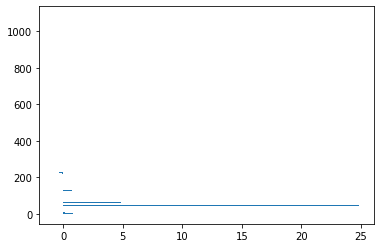

In [32]:
plt.barh(np.arange(len(gas.net_rates_of_progress)),gas.net_rates_of_progress)

In [33]:
gas.T

1897.007898142635

In [34]:
data = pd.read_csv(output_filename)
data

,Distance (mm),T (C),P (atm),Ne,NH3(2),NH2OH(3),HNO3(4),CH3OH(5),H2O(6),N2(7),...,H3NOX(205),NO2X(206),NO3X(207),HNO3X(208),CH3OX(209),CH3OX(210),CH4OX(211),gas_heat,surface_heat,alpha
0,0.0000,400.000000,1.0,0.000000e+00,3.065562e-26,8.478019e-31,3.530430e-12,-4.793499e-44,0.676343,0.195673,...,5.459949e-41,7.526949e-12,1.764887e-21,1.200287e-22,-7.016004e-41,-1.242489e-32,-5.337359e-46,2.511948e-18,-3.757541e-09,1.000000
1,0.0055,400.000000,1.0,0.000000e+00,3.065562e-26,8.478019e-31,3.530430e-12,-7.668369e-44,0.676343,0.195673,...,5.459949e-41,7.526950e-12,1.764887e-21,1.200287e-22,-2.512804e-42,-4.449931e-34,-2.916847e-47,2.012953e-18,-3.420664e-09,1.000000
2,0.0110,400.000000,1.0,0.000000e+00,3.065562e-26,8.478019e-31,3.530430e-12,-7.615802e-44,0.676343,0.195673,...,-3.263804e-39,7.526950e-12,1.764887e-21,1.200287e-22,-2.497067e-42,-4.422063e-34,-2.898580e-47,1.334992e-18,1.966040e-09,1.000000
3,0.0165,400.000000,1.0,0.000000e+00,3.065562e-26,8.378117e-31,3.530430e-12,-7.252857e-44,0.676343,0.195673,...,7.827883e-33,7.526950e-12,1.764887e-21,1.200287e-22,-2.373505e-42,-4.203246e-34,-2.755149e-47,7.454871e-19,-3.242386e-09,1.000000
4,0.0220,400.000000,1.0,0.000000e+00,3.065562e-26,8.378977e-31,3.530430e-12,-9.872098e-57,0.676343,0.195673,...,2.581331e-35,7.526950e-12,1.764887e-21,1.200287e-22,1.911952e-53,4.587839e-45,1.503230e-58,-1.903212e-19,-4.842523e-10,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,1.7270,1604.289821,1.0,1.479559e-48,1.328431e-01,7.332622e-05,1.993307e-06,1.040872e-06,0.434783,0.003573,...,2.417515e-09,1.252032e-05,9.080604e-08,3.530293e-11,8.301836e-15,2.806988e-13,2.814018e-11,-8.965734e+09,1.482584e+09,-0.198123
320,1.7325,1608.116905,1.0,1.479056e-48,1.322478e-01,7.215609e-05,1.873312e-06,9.363377e-07,0.435606,0.003690,...,2.356113e-09,1.196865e-05,8.682754e-08,3.286661e-11,7.793503e-15,2.596896e-13,2.521454e-11,-9.112361e+09,1.544690e+09,-0.204117
321,1.7380,1611.986390,1.0,1.478547e-48,1.316454e-01,7.099733e-05,1.758765e-06,8.416837e-07,0.436437,0.003812,...,2.295845e-09,1.143389e-05,8.292816e-08,3.056518e-11,7.320796e-15,2.404145e-13,2.257556e-11,-9.260415e+09,1.606420e+09,-0.209880
322,1.7435,1615.899148,1.0,1.478033e-48,1.310358e-01,6.984928e-05,1.649532e-06,7.560293e-07,0.437274,0.003939,...,2.236676e-09,1.091576e-05,7.911061e-08,2.839355e-11,6.880730e-15,2.227154e-13,2.019673e-11,-9.409889e+09,1.667780e+09,-0.215417


In [35]:
def xlabels():
    plt.xticks([0,NReactors/4,NReactors/2,3*NReactors/4, NReactors],['0','','','',f'{length*1000:.0f} mm'])
    plt.xlabel("Distance down reactor")

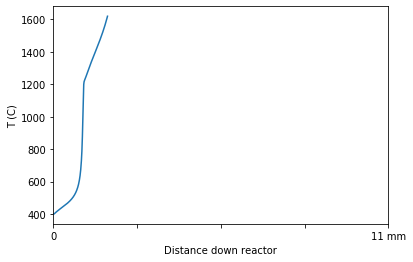

In [36]:
data['T (C)'].plot()
plt.ylabel('T (C)')
xlabels()

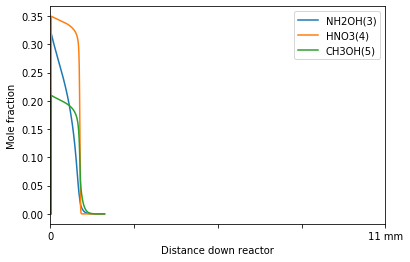

In [37]:
data[['NH2OH(3)', 'HNO3(4)', 'CH3OH(5)']].plot()
plt.ylabel('Mole fraction')
xlabels()

In [38]:
list(data.columns)[:4]

['Distance (mm)', 'T (C)', 'P (atm)', 'Ne']

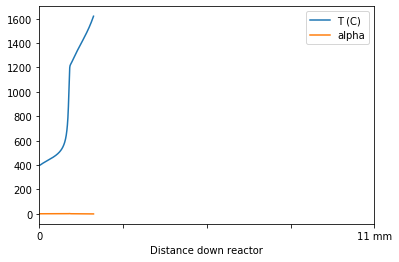

In [39]:
data[['T (C)', 'alpha']].plot()
xlabels()

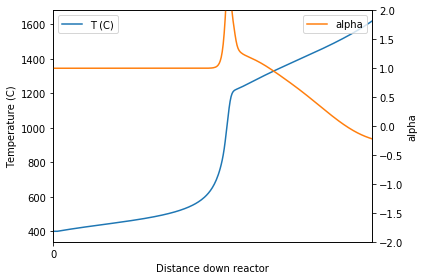

In [40]:
ax1 = data['T (C)'].plot()
plt.ylabel('Temperature (C)')
xlabels()
plt.legend()
ax2 = ax1.twinx()
data['alpha'].plot(ax=ax2, color='tab:orange')
ax2.set_ylim(-2, 2)
plt.legend()
plt.ylabel('alpha')
plt.tight_layout()
plt.savefig('temperature-and-alpha.pdf')
plt.show()

In [41]:
data.columns

Index(['Distance (mm)', 'T (C)', 'P (atm)', 'Ne', 'NH3(2)', 'NH2OH(3)',
       'HNO3(4)', 'CH3OH(5)', 'H2O(6)', 'N2(7)', 'O2(8)', 'NO2(9)', 'NO(10)',
       'N2O(11)', 'CO2(12)', 'H2(13)', 'CO(14)', 'CH4(15)', 'C2H6(16)',
       'CH2O(17)', 'CH3(18)', 'C3H8(19)', 'H(20)', 'C2H5(21)', 'HCO(22)',
       'CH3CHO(23)', 'OH(24)', 'C2H4(25)', 'O(36)', 'Ar(37)', 'He(38)',
       'HO2(39)', 'H2O2(40)', 'HOCO(41)', 'CH2(42)', 'CH2(S)(43)', 'CH(44)',
       'CH2OH(45)', 'CH3O(46)', 'HCOH(47)', 'CH3OO(48)', 'CH2CO(49)',
       'C2H3(50)', 'C(51)', 'C2H2(52)', 'C2H(53)', 'CH3OOH(54)', 'CH2OOH(55)',
       'HOCH2O(56)', 'HOCHO(57)', 'C2H5O(58)', 'C2H5O2(59)', 'C2H5O2(60)',
       'cC2H4O(61)', 'CH2CHO(62)', 'H2CC(63)', 'CH3CO(64)', 'C2H4O(65)',
       'C2H5O(66)', 'C2H3O2(67)', 'CHCHO(68)', 'OCHCHO(69)', 'NH2(85)',
       'H2NO(88)', 'HNOH(93)', 'NO3(95)', 'H2NO3(239)', 'X(1)', 'HX(26)',
       'OX(27)', 'CH3X(28)', 'HOX(29)', 'H2OX(30)', 'CO2X(31)', 'OCX(32)',
       'CX(33)', 'CH2X(34)', 'CHX(35)

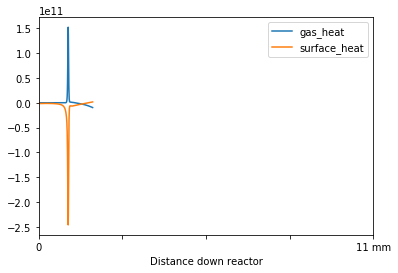

In [42]:
data[['gas_heat','surface_heat']].plot()
#plt.ylim(-1e7, 1e7)
xlabels()
plt.savefig('gas_and_surface_heat.pdf')
plt.show()


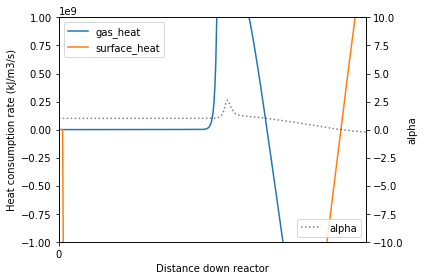

In [43]:
ax1 = data[['gas_heat','surface_heat']].plot()
plt.ylim(-1e9, 1e9)
xlabels()
plt.ylabel('Heat consumption rate (kJ/m3/s)')
plt.legend(loc='upper left')
ax2 = ax1.twinx()
data['alpha'].plot(ax=ax2, style='k:', alpha=0.5)
ax2.set_ylim(-10, 10)
plt.legend(loc='lower right')
plt.ylabel('alpha')
plt.tight_layout()
plt.savefig('heats-and-alpha.pdf')
plt.show()

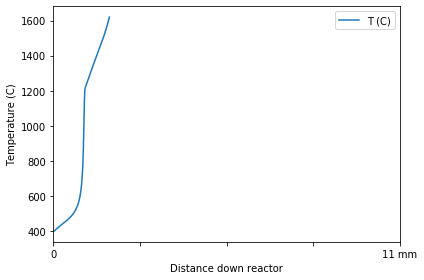

In [44]:
data[['T (C)']].plot()
plt.ylabel('Temperature (C)')
xlabels()
plt.tight_layout()
plt.savefig('temperature.pdf')
plt.show()

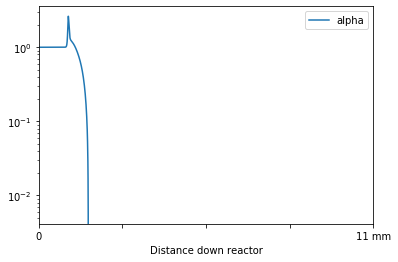

In [45]:
data[['alpha']].plot(logy=True)
xlabels()

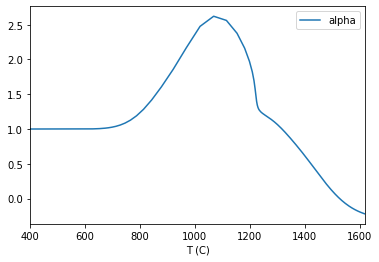

In [46]:
data.plot(x='T (C)',y='alpha')


In [47]:
specs = list(data.columns)
specs = specs[4:-1]

gas_species = [s for s in specs if 'X' not in s]
adsorbates = [s for s in specs if 'X' in s]

gas_species, adsorbates

(['NH3(2)',
  'NH2OH(3)',
  'HNO3(4)',
  'CH3OH(5)',
  'H2O(6)',
  'N2(7)',
  'O2(8)',
  'NO2(9)',
  'NO(10)',
  'N2O(11)',
  'CO2(12)',
  'H2(13)',
  'CO(14)',
  'CH4(15)',
  'C2H6(16)',
  'CH2O(17)',
  'CH3(18)',
  'C3H8(19)',
  'H(20)',
  'C2H5(21)',
  'HCO(22)',
  'CH3CHO(23)',
  'OH(24)',
  'C2H4(25)',
  'O(36)',
  'Ar(37)',
  'He(38)',
  'HO2(39)',
  'H2O2(40)',
  'HOCO(41)',
  'CH2(42)',
  'CH2(S)(43)',
  'CH(44)',
  'CH2OH(45)',
  'CH3O(46)',
  'HCOH(47)',
  'CH3OO(48)',
  'CH2CO(49)',
  'C2H3(50)',
  'C(51)',
  'C2H2(52)',
  'C2H(53)',
  'CH3OOH(54)',
  'CH2OOH(55)',
  'HOCH2O(56)',
  'HOCHO(57)',
  'C2H5O(58)',
  'C2H5O2(59)',
  'C2H5O2(60)',
  'cC2H4O(61)',
  'CH2CHO(62)',
  'H2CC(63)',
  'CH3CO(64)',
  'C2H4O(65)',
  'C2H5O(66)',
  'C2H3O2(67)',
  'CHCHO(68)',
  'OCHCHO(69)',
  'NH2(85)',
  'H2NO(88)',
  'HNOH(93)',
  'NO3(95)',
  'H2NO3(239)',
  'gas_heat',
  'surface_heat'],
 ['X(1)',
  'HX(26)',
  'OX(27)',
  'CH3X(28)',
  'HOX(29)',
  'H2OX(30)',
  'CO2X(31)',
  'OCX(32

/Users/rwest/opt/anaconda3/envs/rmg3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(left, right)


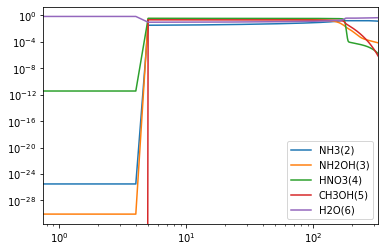

In [48]:
data[gas_species[0:5]].plot(logy=True, logx=True)

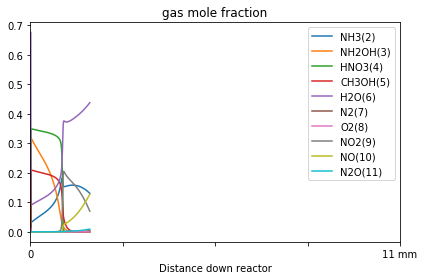

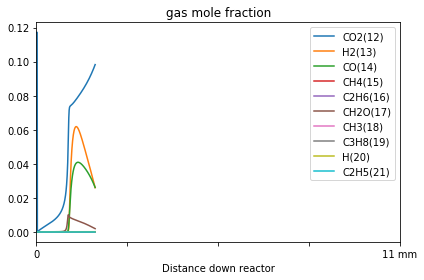

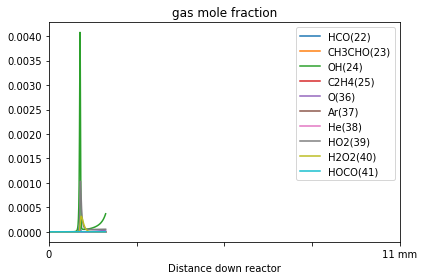

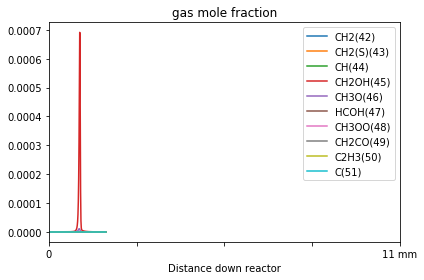

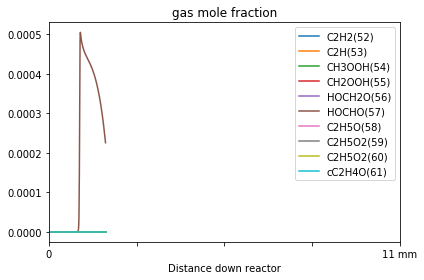

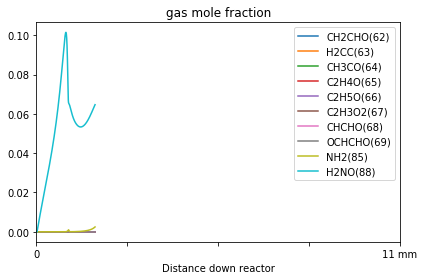

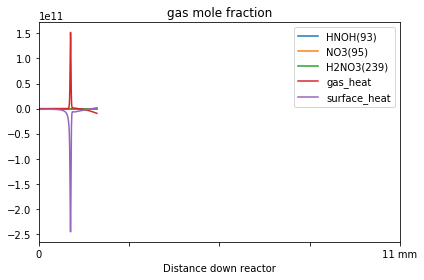

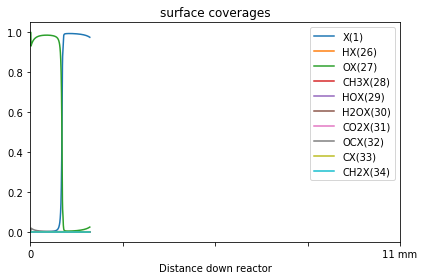

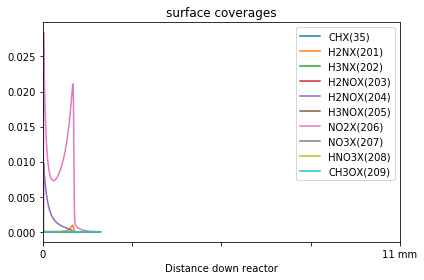

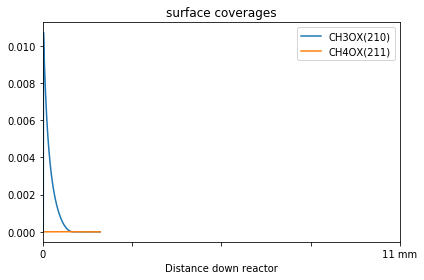

In [49]:
for i in range(0,len(gas_species),10):
    data[gas_species[i:i+10]].plot(title='gas mole fraction', logy=False)
    xlabels()
    plt.tight_layout()
    plt.savefig(f'gas_mole_fractions_{i}.pdf')
    plt.show()
    
for i in range(0,len(adsorbates),10):
    data[adsorbates[i:i+10]].plot(title='surface coverages', logy=False)
    xlabels()
    plt.tight_layout()
    plt.savefig(f'surface_coverages_{i}.pdf')
    plt.show()

In [50]:
gas.species('NO2(9)').composition

{'N': 1.0, 'O': 2.0}

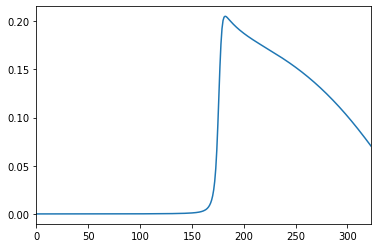

In [51]:
data['NO2(9)'].plot()

In [52]:
(data[specs].max()>0.01)

NH3(2)           True
NH2OH(3)         True
HNO3(4)          True
CH3OH(5)         True
H2O(6)           True
                ...  
CH3OX(209)      False
CH3OX(210)       True
CH4OX(211)      False
gas_heat         True
surface_heat     True
Length: 87, dtype: bool

In [ ]:
data.loc[0]